In [1]:
import collections
import itertools
import random
import requests
import multiprocessing

import pandas as pd

import numpy as np

from backend.config import config
from backend.lib.fetch import representative_points
from backend.lib.database.postgres import connect
from backend.lib.calculate import adequacy

import matplotlib
import matplotlib.pyplot as plt

try:
    import seaborn as sns
except ModuleNotFoundError:
    !pip install seaborn
    import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8)
pd.set_option('max_columns', 999)

In [2]:
all_service_areas = requests.get('http://52.53.130.100:8080/api/available-service-areas/').json()
service_area_ids = [sa[0] for sa in all_service_areas if sa[3] == 'TX']
raw_points = representative_points.fetch_representative_points(
    service_area_ids=service_area_ids, format_response=False
)

In [3]:
def dataframe_from_points(points):
    df = pd.DataFrame(points)
    df.drop(
        labels=['census_block', 'census_block_group', 'created_at', 'isodistancePolygon', 'updated_at'],
        axis=1,
        inplace=True
    )
    df['population'] = df['population'].apply(lambda d: d['1.0'])
    df['state'] = df['service_area_id'].apply(lambda s: s[:2].upper())
    return df

In [4]:
df = dataframe_from_points(raw_points)
df.head(3)

,census_tract,county,id,latitude,location,longitude,population,service_area_id,zip_code,state
0,48213951100,Anderson,166087,32.021217,0101000020E610000058CEFE7032FB57C098E86E3CB702...,-95.924954,24,tx_anderson_75751,75751,TX
1,48001951100,Anderson,158515,31.959976,0101000020E6100000307EFEA1F70158C0E09592FCC0F5...,-96.030739,30,tx_anderson_75751,75751,TX
2,48001951100,Anderson,158514,31.991356,0101000020E6100000D8DE5A6507FF57C0B0E8067FC9FD...,-95.984826,11,tx_anderson_75751,75751,TX


In [5]:
def fetch_demographics():
    engine = connect.create_db_engine()
    result = engine.execute("SELECT * FROM census_tract_demographics WHERE state = 'Texas';")
    df = pd.DataFrame(result.fetchall(), columns=result.keys())
    return df

In [6]:
demos = fetch_demographics()

In [7]:
demos.head(4)

,census_tract,state,county,total_pop,men,women,hispanic,white,black,native,asian,pacific,citizen,income,income_err,income_per_cap,income_per_cap_err,poverty,child_poverty,professional,service,office,construction,production,drive,carpool,transit,walk,other_transp,work_at_home,mean_commute,employed,private_work,public_work,self_employed,family_work,unemployment
0,48071990000,Texas,Chambers,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
1,48085031309,Texas,Collin,9088,4432,4656,19.7,55.7,14.6,1.0,6.7,0.0,6047,76190.0,6758.0,28636.0,2222.0,4.1,3.4,34.9,9.2,39.5,7.9,8.5,84.9,9.9,0.3,0.0,2.1,2.9,36.5,5040,81.9,14.6,3.5,0.0,7.7
2,48085031310,Texas,Collin,10126,4945,5181,15.5,70.9,7.5,0.8,2.2,0.0,6748,73562.0,6024.0,25668.0,2514.0,5.5,5.8,41.3,9.2,26.3,13.4,9.9,88.9,5.6,1.5,0.0,0.8,3.1,29.5,4925,84.9,8.3,6.8,0.0,8.4
3,48085031311,Texas,Collin,10936,5466,5470,16.8,69.4,6.5,0.2,3.4,0.0,7121,92754.0,13313.0,31976.0,2712.0,4.5,1.2,50.6,10.8,29.1,5.1,4.5,81.3,9.7,0.8,0.6,1.2,6.4,32.2,5677,84.7,12.4,2.9,0.0,4.5


In [8]:
points = pd.merge(
    df,
    demos[[col for col in demos.columns if col not in df.columns] + ['census_tract']], 
    how='inner',
    on='census_tract'
)

In [9]:
points[points['county'] == 'DeWitt'].head(5)

,census_tract,county,id,latitude,location,longitude,population,service_area_id,zip_code,state,total_pop,men,women,hispanic,white,black,native,asian,pacific,citizen,income,income_err,income_per_cap,income_per_cap_err,poverty,child_poverty,professional,service,office,construction,production,drive,carpool,transit,walk,other_transp,work_at_home,mean_commute,employed,private_work,public_work,self_employed,family_work,unemployment
38111,48469001400,DeWitt,130210,28.951810,0101000020E6100000343DE60BF34B58C0002EB7D7A9F3...,-97.186709,2,tx_dewitt_77905,77905,TX,8340,4206,4134,30.1,67.0,1.3,0.1,0.7,0.0,6365,73230.0,6111.0,31120.0,3509.0,8.8,8.2,30.6,11.2,26.2,20.3,11.8,86.1,8.0,2.1,0.3,0.4,3.1,28.4,4014,82.0,12.3,5.2,0.5,3.9
38181,48123970400,DeWitt,151929,29.076701,0101000020E6100000EC6C2F6CA45158C0604AD8AFA213...,-97.275661,160,tx_dewitt_77954,77954,TX,3837,1909,1928,26.1,71.0,2.4,0.1,0.0,0.0,2854,50363.0,14391.0,28506.0,4626.0,12.6,17.3,25.2,16.1,21.8,24.8,12.1,89.7,3.9,0.0,0.9,1.4,4.0,29.3,1704,77.6,14.6,7.8,0.0,4.2
38182,48123970400,DeWitt,151928,29.078742,0101000020E61000005045C8AB195358C000A12F762814...,-97.298442,495,tx_dewitt_77954,77954,TX,3837,1909,1928,26.1,71.0,2.4,0.1,0.0,0.0,2854,50363.0,14391.0,28506.0,4626.0,12.6,17.3,25.2,16.1,21.8,24.8,12.1,89.7,3.9,0.0,0.9,1.4,4.0,29.3,1704,77.6,14.6,7.8,0.0,4.2
38183,48123970400,DeWitt,151927,29.066180,0101000020E61000001856170E695258C0704AAF30F110...,-97.287662,25,tx_dewitt_77954,77954,TX,3837,1909,1928,26.1,71.0,2.4,0.1,0.0,0.0,2854,50363.0,14391.0,28506.0,4626.0,12.6,17.3,25.2,16.1,21.8,24.8,12.1,89.7,3.9,0.0,0.9,1.4,4.0,29.3,1704,77.6,14.6,7.8,0.0,4.2
38184,48123970400,DeWitt,151926,29.082330,0101000020E61000003C1B05FD2F5458C0E03614971315...,-97.315429,219,tx_dewitt_77954,77954,TX,3837,1909,1928,26.1,71.0,2.4,0.1,0.0,0.0,2854,50363.0,14391.0,28506.0,4626.0,12.6,17.3,25.2,16.1,21.8,24.8,12.1,89.7,3.9,0.0,0.9,1.4,4.0,29.3,1704,77.6,14.6,7.8,0.0,4.2


In [10]:
def get_latitude_longitude_from_csv(path):
    tmp = pd.read_csv(path)
    return [{'latitude': row[0], 'longitude': row[1]} for row in tmp[['Latitude', 'Longitude']].values.tolist()]

In [11]:
provider_locations=get_latitude_longitude_from_csv('../data/Texas/texas_abortion_clinics_address_post_hb2.csv')

In [12]:
engine = connect.create_db_engine()
adequacy_response = adequacy.calculate_adequacies(service_area_ids, locations=provider_locations, engine=engine)

In [13]:
closest_distance_by_point = {
    point['id']: point['distance_to_closest_provider'] for point in adequacy_response
}
points['distance_to_closest_provider'] = points.apply(
    axis=1,
    func=lambda row: closest_distance_by_point[row['id']]
)

In [14]:
points[points['county'] == 'Dallas'].head(4)

,census_tract,county,id,latitude,location,longitude,population,service_area_id,zip_code,state,total_pop,men,women,hispanic,white,black,native,asian,pacific,citizen,income,income_err,income_per_cap,income_per_cap_err,poverty,child_poverty,professional,service,office,construction,production,drive,carpool,transit,walk,other_transp,work_at_home,mean_commute,employed,private_work,public_work,self_employed,family_work,unemployment,distance_to_closest_provider
34195,48113013726,Dallas,185164,32.949584,0101000020E61000007019018CBC3658C0183862F88B79...,-96.855258,2753,tx_dallas_75001,75001,TX,2979,1438,1541,27.5,51.6,5.8,0.6,12.6,0.0,1887,81875.0,30814.0,44128.0,5465.0,2.6,0.0,49.4,9.4,29.6,2.9,8.7,83.4,3.8,1.8,2.1,0.8,8.2,21.0,2042,85.0,8.5,6.5,0.0,2.2,7.062153
34196,48113013726,Dallas,184732,32.940010,0101000020E6100000FC893B253A3658C0706E7D3F5278...,-96.847299,2044,tx_dallas_75244,75244,TX,2979,1438,1541,27.5,51.6,5.8,0.6,12.6,0.0,1887,81875.0,30814.0,44128.0,5465.0,2.6,0.0,49.4,9.4,29.6,2.9,8.7,83.4,3.8,1.8,2.1,0.8,8.2,21.0,2042,85.0,8.5,6.5,0.0,2.2,6.325604
34197,48113013805,Dallas,185163,32.933541,0101000020E6100000ECDCA7EFC43658C0C827F1477E77...,-96.855770,4823,tx_dallas_75001,75001,TX,3518,1792,1726,39.3,36.6,13.2,0.2,9.4,0.0,2189,43429.0,5997.0,32060.0,4510.0,21.4,31.0,46.6,16.4,24.6,5.4,7.0,87.3,4.7,0.8,1.4,1.5,4.2,21.4,2291,91.4,6.0,2.6,0.0,3.1,6.561423
34198,48113013806,Dallas,184730,32.940628,0101000020E61000002C2967BDB23558C018874F816678...,-96.839034,919,tx_dallas_75001,75001,TX,3241,1545,1696,10.3,51.2,12.2,0.0,22.2,0.0,2361,70325.0,5488.0,45734.0,4387.0,2.2,2.3,63.3,10.0,20.7,1.3,4.7,88.3,4.3,0.3,1.2,1.2,4.7,20.9,2293,84.0,10.6,5.2,0.2,2.4,5.936967


In [15]:
def get_access_category(distance):
    if distance <= 15.0:
        return 'ADEQUATE_15'
    elif distance <= 30.0:
        return 'ADEQUATE_30'
    elif distance <= 60.0:
        return 'ADEQUATE_60'
    else:
        return 'INADEQUATE'

points['label'] = points['distance_to_closest_provider'].apply(get_access_category)
points['dummy_weight'] = 100.0

In [16]:
def donut(df, weight_column):
    cols = ['population', weight_column, 'label']
    mini_df = points[cols].values.tolist()
    labels = ['ADEQUATE_15', 'ADEQUATE_30', 'ADEQUATE_60', 'INADEQUATE']
    
    size_by_label = collections.defaultdict(float)
    for row in mini_df:
        if row[0] and row[1] and row[0] < float('inf') and row[1] < float('inf'):
            size_by_label[row[2]] += (row[0] * row[1])/100.0

    sizes = [size_by_label[label] for label in labels]
    colors = ['#3949ab', '#7986cb', '#ff8a65', '#f4511e']
    explode = (0, 0, 0, 0)  # explode a slice if required
    plt.pie(sizes, explode=explode, labels=labels, colors=colors,
            autopct='%1.1f%%', shadow=True)
        
#     #draw a circle at the center of pie to make it look like a donut
    centre_circle = plt.Circle((0,0),0.5,color='black', fc='white',linewidth=1.25)
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    # Set aspect ratio to be equal so that pie is drawn as a circle.
    plt.axis('equal')
    plt.title('Texas Abortion Clinics - Post HB2 - {} population'.format(weight_column))
    plt.show()  

In [17]:
float_cols = [
    col for col in points.columns if points.dtypes[col] == np.dtype('float64')
    if col not in {
        'latitude', 'longitude', 'income', 'income_err', 'income_per_cap', \
        'income_per_cap_err', 'distance_to_closest_provider', \
        'employed', 'mean_commute'
    }
]

In [18]:
# donut(points, 'dummy_weight')
# for col in float_cols:
#     donut(points, col)

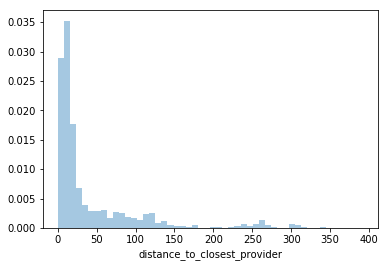

In [19]:
sns.distplot(
    a=points['distance_to_closest_provider'],
    kde=False,
    hist_kws={
        'weights': points['population'], 'normed': True
    },
)

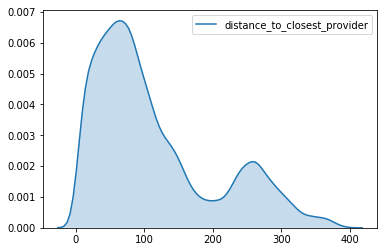

In [20]:
sns.kdeplot(points['distance_to_closest_provider'], shade=True)

In [21]:
"""def repeat_points_according_to_weight_population(data, weights):
    # Unspool the data, repeating each point according to its weight.
    return_value = []
    for obs, weight in zip(data, weights):
        return_value.extend([obs]*int(weight+1))
    return pd.DataFrame(return_value)

large_df = repeat_points_according_to_weight_population(points['distance_to_closest_provider'], points['population'] / 20)

sns.distplot(
    a=large_df,
    kde=True,
    hist_kws={
        'normed': True
    },
)

sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

points.fillna(0.0, inplace=True)
# Create the data
native_df = repeat_points_according_to_weight_population(
    data=points['distance_to_closest_provider'],
    weights=points['population']*points['native']/100/20
)
native_df['race'] = 'native'
asian_df = repeat_points_according_to_weight_population(
    data=points['distance_to_closest_provider'],
    weights=points['population']*points['asian']/100/20
)
asian_df['race'] = 'asian'

full_df = pd.concat([native_df, asian_df])

pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(full_df, row='race', hue='race', aspect=15, size=6, palette=pal)
g.map(sns.kdeplot, 0, clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, 0, clip_on=False, color="w", lw=1.5, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontsize=36, fontweight="bold", color=color, 
            ha="left", va="center", transform=ax.transAxes)

g.map(label, 0)
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

plt.show()
"""

'def repeat_points_according_to_weight_population(data, weights):\n    # Unspool the data, repeating each point according to its weight.\n    return_value = []\n    for obs, weight in zip(data, weights):\n        return_value.extend([obs]*int(weight+1))\n    return pd.DataFrame(return_value)\n\nlarge_df = repeat_points_according_to_weight_population(points[\'distance_to_closest_provider\'], points[\'population\'] / 20)\n\nsns.distplot(\n    a=large_df,\n    kde=True,\n    hist_kws={\n        \'normed\': True\n    },\n)\n\nsns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})\n\npoints.fillna(0.0, inplace=True)\n# Create the data\nnative_df = repeat_points_according_to_weight_population(\n    data=points[\'distance_to_closest_provider\'],\n    weights=points[\'population\']*points[\'native\']/100/20\n)\nnative_df[\'race\'] = \'native\'\nasian_df = repeat_points_according_to_weight_population(\n    data=points[\'distance_to_closest_provider\'],\n    weights=points[\'population\']*p

In [22]:
def bars(df, weight_column):
    cols = ['population', weight_column, 'label']
    mini_df = points[cols].values.tolist()
    labels = ['ADEQUATE_15', 'ADEQUATE_30', 'ADEQUATE_60', 'INADEQUATE']
    
    size_by_label = collections.defaultdict(float)
    for row in mini_df:
        if row[0] and row[1] and row[0] < float('inf') and row[1] < float('inf'):
            size_by_label[row[2]] += (row[0] * row[1])/100.0

    sizes = [size_by_label[label] for label in labels]
    colors = ['#3949ab', '#7986cb', '#ff8a65', '#f4511e']
    sns.barplot(labels, sizes, palette=colors)

    plt.title('Texas Abortion Clinics - Post HB2 - {} population'.format(weight_column))
    sns.despine(bottom=True)
    plt.setp(f.axes, yticks=[])
    plt.tight_layout(h_pad=3)
    plt.show()  

In [23]:
# bars(points, 'dummy_weight')
# for col in float_cols:
#     bars(points, col);

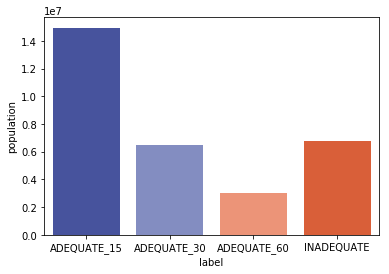

In [24]:
points2 = points.copy()
for col in float_cols:
    points2[col] = points2['population'] * points2[col] / 100.0

g = points2.groupby('label').sum().reset_index()
ax = sns.barplot(x='label', y="population", data=g, palette=['#3949ab', '#7986cb', '#ff8a65', '#f4511e'])

In [25]:
new_data = []
for col in ['population', 'white', 'hispanic', 'black', 'asian', 'native']:
    for row in g.iterrows():
        new_data.append({
            'label': row[1]['label'],
            'race': col,
            'count': row[1][col]
        })
        
ndf = pd.DataFrame(new_data)
tmp = ndf.groupby('race')['count'].sum().to_dict()
ndf['percent'] = ndf.apply(lambda row: row['count'] / (tmp[row['race']]), axis=1)
ndf.head(5)

,count,label,race,percent
0,1.493757e+07,ADEQUATE_15,population,0.477580
1,6.509564e+06,ADEQUATE_30,population,0.208122
2,3.057330e+06,ADEQUATE_60,population,0.097748
3,6.773138e+06,INADEQUATE,population,0.216549
4,4.878823e+06,ADEQUATE_15,white,0.347784


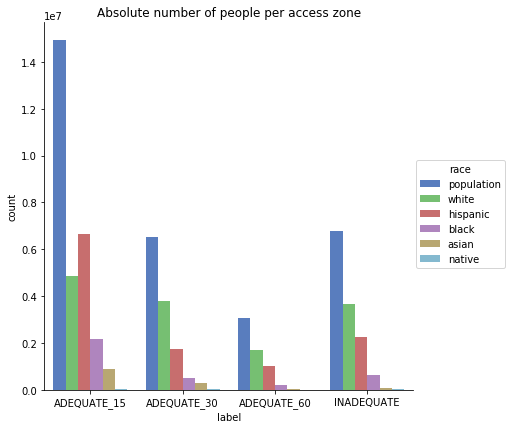

In [26]:
g2 = sns.factorplot(
    x="label", y="count", hue='race', data=ndf,
    size=6, kind="bar", palette="muted"
)
plt.title('Absolute number of people per access zone');

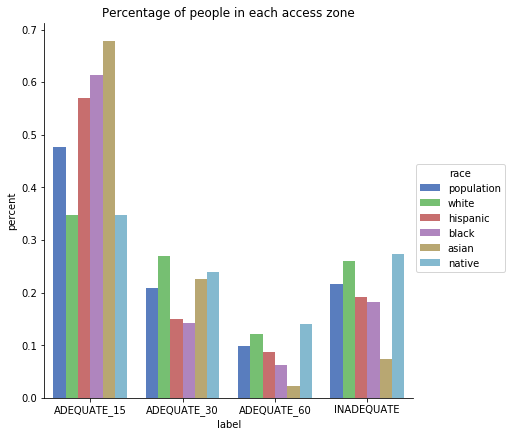

In [27]:
g3 = sns.factorplot(
    x="label", y="percent", hue='race', data=ndf,
    size=6, kind="bar", palette="muted"
)
plt.title('Percentage of people in each access zone');

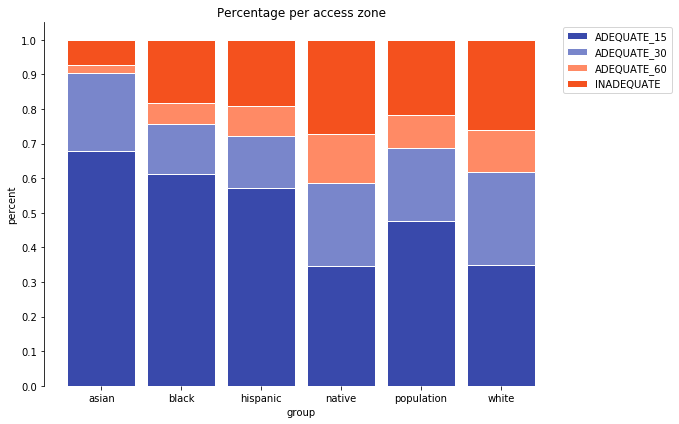

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd


fig = plt.figure(figsize=(8,6))
# Data
raw_data = {'greenBars': [20, 1.5, 7, 10, 5], 'orangeBars': [5, 15, 5, 10, 15],'blueBars': [2, 15, 18, 5, 10]}
df = pd.DataFrame(raw_data)

colors = ['#3949ab', '#7986cb', '#ff8a65', '#f4511e']
labels = ['ADEQUATE_15', 'ADEQUATE_30', 'ADEQUATE_60', 'INADEQUATE']
groups = ['population', 'white', 'hispanic', 'black', 'asian', 'native']

raw_data = collections.defaultdict(list)
mapping = ndf.groupby(['label', 'race'])['percent'].sum().to_dict()
for adequacy_class in labels:
    for group in groups:
        raw_data[adequacy_class].append(
            mapping[(adequacy_class, group)]
        )

# plot
barWidth = 0.85
plt.bar(groups, raw_data['ADEQUATE_15'], color=colors[0], edgecolor='white', width=barWidth, label=labels[0])
plt.bar(groups, raw_data['ADEQUATE_30'], bottom=raw_data['ADEQUATE_15'], color=colors[1], edgecolor='white', width=barWidth, label=labels[1])
plt.bar(groups, raw_data['ADEQUATE_60'], bottom=[i + j for i, j in zip(raw_data['ADEQUATE_30'], raw_data['ADEQUATE_15'])], color=colors[2], edgecolor='white', width=barWidth, label=labels[2])
plt.bar(groups, raw_data['INADEQUATE'], bottom=[i + j + k for i, j, k in zip(raw_data['ADEQUATE_60'], raw_data['ADEQUATE_30'], raw_data['ADEQUATE_15'])], color=colors[3], edgecolor='white', width=barWidth, label=labels[3])

# Custom x axis
plt.xticks(groups, groups)
plt.xlabel("group")
plt.ylabel('percent')
plt.yticks(np.arange(0.0, 1.1, 0.1))
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)

plt.title('Percentage per access zone');

sns.despine(bottom=True)
plt.tight_layout(h_pad=3)
# Show graphic
plt.show()

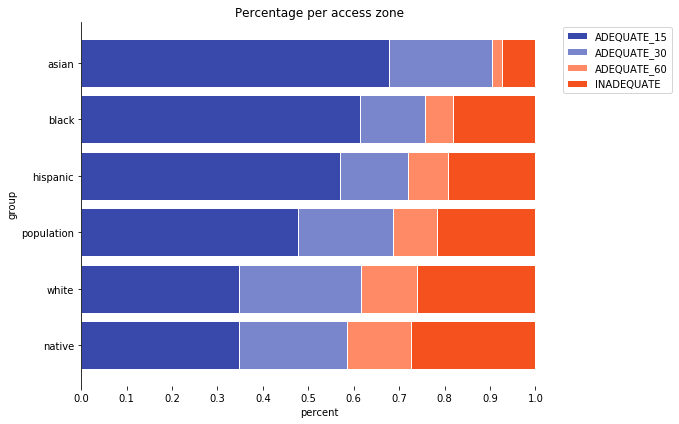

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd


fig = plt.figure(figsize=(8,6))
# Data
colors = ['#3949ab', '#7986cb', '#ff8a65', '#f4511e']
labels = ['ADEQUATE_15', 'ADEQUATE_30', 'ADEQUATE_60', 'INADEQUATE']
groups = ['population', 'white', 'hispanic', 'black', 'asian', 'native']
y_vals = list(range(len(groups)))

raw_data = collections.defaultdict(list)
mapping = ndf.groupby(['label', 'race'])['percent'].sum().to_dict()
for adequacy_class in labels:
    for group in groups:
        raw_data[adequacy_class].append(
            mapping[(adequacy_class, group)]
        )

sorted_indices = np.argsort([i+j for i,j in zip(raw_data['ADEQUATE_15'], raw_data['ADEQUATE_30'])])
for k, v in raw_data.items():
    raw_data[k] = [v[i] for i in sorted_indices]
groups = [groups[i] for i in sorted_indices]

# plot
barWidth = 0.85
plt.barh(y_vals, raw_data['ADEQUATE_15'], color=colors[0], edgecolor='white', height=barWidth, label=labels[0])
plt.barh(y_vals, raw_data['ADEQUATE_30'], left=raw_data['ADEQUATE_15'], color=colors[1], edgecolor='white', height=barWidth, label=labels[1],)
plt.barh(y_vals, raw_data['ADEQUATE_60'], left=[i + j for i, j in zip(raw_data['ADEQUATE_30'], raw_data['ADEQUATE_15'])], color=colors[2], edgecolor='white', height=barWidth, label=labels[2],)
plt.barh(y_vals, raw_data['INADEQUATE'], left=[i + j + k for i, j, k in zip(raw_data['ADEQUATE_60'], raw_data['ADEQUATE_30'], raw_data['ADEQUATE_15'])], color=colors[3], edgecolor='white', height=barWidth, label=labels[3],)

# Custom x axis
plt.yticks(y_vals, groups)
plt.ylabel("group")
plt.xlabel('percent')
plt.xticks(np.arange(0.0, 1.1, 0.1))
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)

plt.title('Percentage per access zone');

sns.despine(bottom=True)
plt.tight_layout(h_pad=3)
# Show graphic
plt.show()

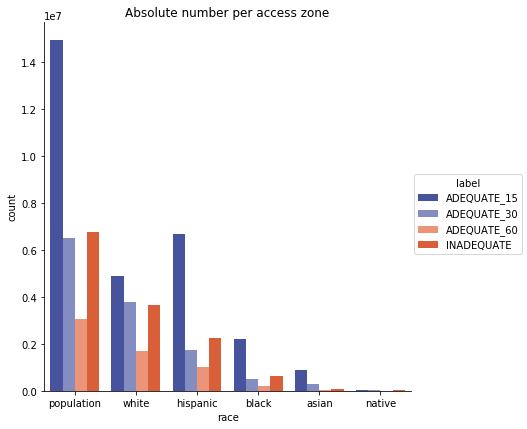

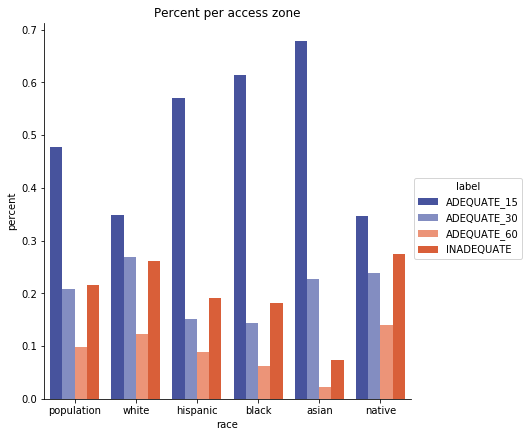

In [30]:
g2 = sns.factorplot(
    x="race", y="count", hue='label', data=ndf,
    size=6, kind="bar", palette=['#3949ab', '#7986cb', '#ff8a65', '#f4511e']
)
plt.title('Absolute number per access zone');
g8 = sns.factorplot(
    x="race", y="percent", hue='label', data=ndf,
    size=6, kind="bar", palette=['#3949ab', '#7986cb', '#ff8a65', '#f4511e']
)
plt.title('Percent per access zone');

In [31]:
def some_people_plot_it_all(df, groups, sort_keys=['ADEQUATE_15', 'ADEQUATE_30'], reverse=False):
    new_data = []
    for col in groups:
        for row in df.iterrows():
            new_data.append({
                'label': row[1]['label'],
                'group': col,
                'count': row[1][col]
            })

    ndf = pd.DataFrame(new_data)
    tmp = ndf.groupby('group')['count'].sum().to_dict()
    ndf['percent'] = ndf.apply(lambda row: row['count'] / (tmp[row['group']]) if tmp[row['group']] else 0.0, axis=1)
    fig = plt.figure(figsize=(8,6))
    # Data
    colors = ['#3949ab', '#7986cb', '#ff8a65', '#f4511e']
    labels = ['ADEQUATE_15', 'ADEQUATE_30', 'ADEQUATE_60', 'INADEQUATE']
    y_vals = list(range(len(groups)))

    raw_data = collections.defaultdict(list)
    mapping = ndf.groupby(['label', 'group'])['percent'].sum().to_dict()
    for adequacy_class in labels:
        for group in groups:
            raw_data[adequacy_class].append(
                100*mapping[(adequacy_class, group)]
            )

    sorted_indices = np.argsort([sum(tupl) for tupl in zip(*[raw_data[key] for key in sort_keys])])
    if reverse:
        sorted_indices = sorted_indices[::-1]
    for k, v in raw_data.items():
        raw_data[k] = [v[i] for i in sorted_indices]
    groups = [groups[i] for i in sorted_indices]

    # plot
    barWidth = 0.85
    plt.barh(y_vals, raw_data['ADEQUATE_15'], color=colors[0], edgecolor='white', height=barWidth, label=labels[0])
    plt.barh(y_vals, raw_data['ADEQUATE_30'], left=raw_data['ADEQUATE_15'], color=colors[1], edgecolor='white', height=barWidth, label=labels[1],)
    plt.barh(y_vals, raw_data['ADEQUATE_60'], left=[i + j for i, j in zip(raw_data['ADEQUATE_30'], raw_data['ADEQUATE_15'])], color=colors[2], edgecolor='white', height=barWidth, label=labels[2],)
    plt.barh(y_vals, raw_data['INADEQUATE'], left=[i + j + k for i, j, k in zip(raw_data['ADEQUATE_60'], raw_data['ADEQUATE_30'], raw_data['ADEQUATE_15'])], color=colors[3], edgecolor='white', height=barWidth, label=labels[3],)

    # Custom x axis
    plt.yticks(y_vals, groups)
    plt.ylabel("group")
    plt.xlabel('percent')
    plt.xticks(np.arange(0.0, 109., 10.0))
    plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)

    plt.title('Percentage per access zone');
    sns.despine(bottom=True, left=True)
    plt.tight_layout(h_pad=3)
    # Show graphic
    plt.show()

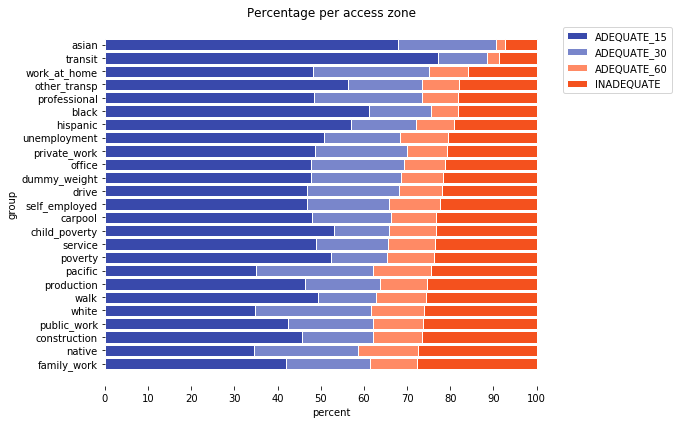

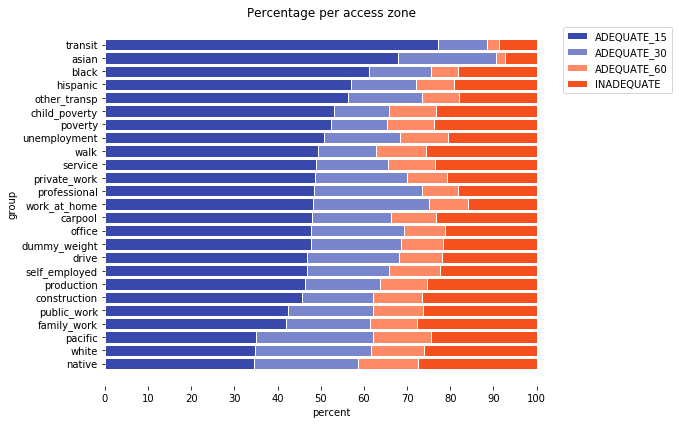

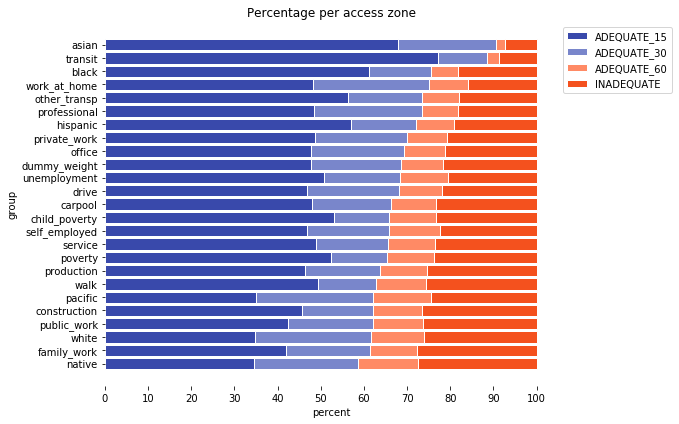

In [32]:
some_people_plot_it_all(df=g, groups=float_cols, sort_keys=['INADEQUATE'], reverse=True)
some_people_plot_it_all(df=g, groups=float_cols, sort_keys=['ADEQUATE_15'])
some_people_plot_it_all(df=g, groups=float_cols, sort_keys=['ADEQUATE_15', 'ADEQUATE_30'])

## ACS Data Profile Tables

In [33]:
def fetch_data_profile_table(number=2):
    """Return the data profile table DP02, DP03, DP04, or DP05."""
    dp = pd.read_csv(
        '../data/census/data-profile-tables/ACS_16_5YR_DP0{}_with_ann.csv'.format(number),
        skiprows=[1],
        encoding='latin-1',
        dtype={'GEO.id2': str}
    )
    column_meanings = pd.read_csv('../data/census/data-profile-tables/ACS_16_5YR_DP0{}_metadata.csv'.format(number), header=None).rename(
        columns={0: 'short', 1: 'long'}
    ).set_index('short')['long'].to_dict()
    return dp, column_meanings

In [34]:
def preview_batch(n, data_profile_table, data_profile_table_columns):
    percentage_cols = [col for col in data_profile_table.columns if '03_' in col][10*n:10*n+10]
    points = pd.merge(
        points2,
        data_profile_table[percentage_cols + ['GEO.id2']], 
        how='inner',
        left_on='census_tract',
        right_on='GEO.id2'
    )

    def impute(val, default_val=0.0):
        try:
            return float(val)
        except ValueError:
            return default_val

    for col in percentage_cols:
        points[col] = points['population']*points[col].apply(impute).astype(float) / 100.0

    g = points.groupby('label').sum().reset_index()
    some_people_plot_it_all(df=g, groups=percentage_cols,sort_keys=['INADEQUATE'], reverse=True)
    for col in percentage_cols:
        print(col, data_profile_table_columns[col])

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2850: DtypeWarning: Columns (4,8,12,16,36,40,44,56,72,84,88,92,96,100,104,108,112,232,260,264,284) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


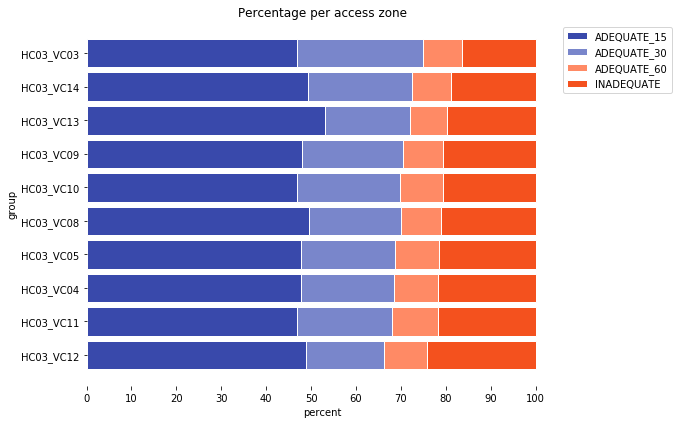

HC03_VC03 Percent; SEX AND AGE - Total population
HC03_VC04 Percent; SEX AND AGE - Total population - Male
HC03_VC05 Percent; SEX AND AGE - Total population - Female
HC03_VC08 Percent; SEX AND AGE - Under 5 years
HC03_VC09 Percent; SEX AND AGE - 5 to 9 years
HC03_VC10 Percent; SEX AND AGE - 10 to 14 years
HC03_VC11 Percent; SEX AND AGE - 15 to 19 years
HC03_VC12 Percent; SEX AND AGE - 20 to 24 years
HC03_VC13 Percent; SEX AND AGE - 25 to 34 years
HC03_VC14 Percent; SEX AND AGE - 35 to 44 years


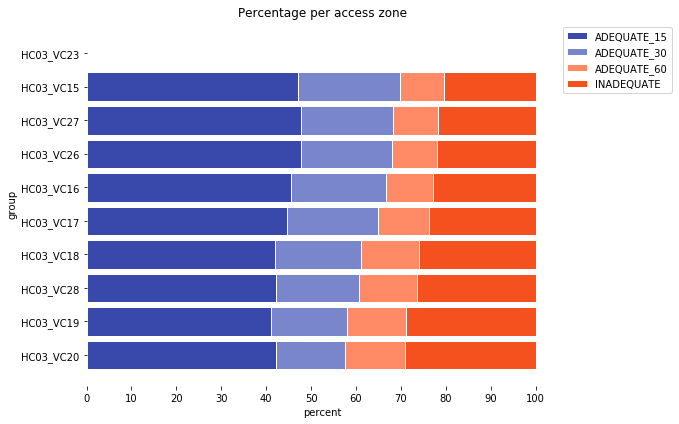

HC03_VC15 Percent; SEX AND AGE - 45 to 54 years
HC03_VC16 Percent; SEX AND AGE - 55 to 59 years
HC03_VC17 Percent; SEX AND AGE - 60 to 64 years
HC03_VC18 Percent; SEX AND AGE - 65 to 74 years
HC03_VC19 Percent; SEX AND AGE - 75 to 84 years
HC03_VC20 Percent; SEX AND AGE - 85 years and over
HC03_VC23 Percent; SEX AND AGE - Median age (years)
HC03_VC26 Percent; SEX AND AGE - 18 years and over
HC03_VC27 Percent; SEX AND AGE - 21 years and over
HC03_VC28 Percent; SEX AND AGE - 62 years and over


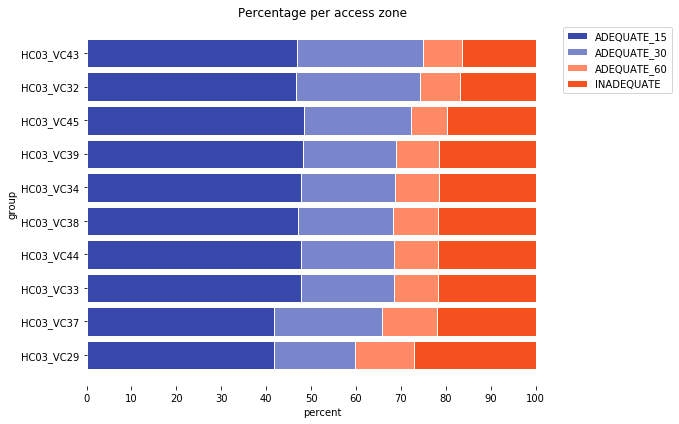

HC03_VC29 Percent; SEX AND AGE - 65 years and over
HC03_VC32 Percent; SEX AND AGE - 18 years and over
HC03_VC33 Percent; SEX AND AGE - 18 years and over - Male
HC03_VC34 Percent; SEX AND AGE - 18 years and over - Female
HC03_VC37 Percent; SEX AND AGE - 65 years and over
HC03_VC38 Percent; SEX AND AGE - 65 years and over - Male
HC03_VC39 Percent; SEX AND AGE - 65 years and over - Female
HC03_VC43 Percent; RACE - Total population
HC03_VC44 Percent; RACE - Total population - One race
HC03_VC45 Percent; RACE - Total population - Two or more races


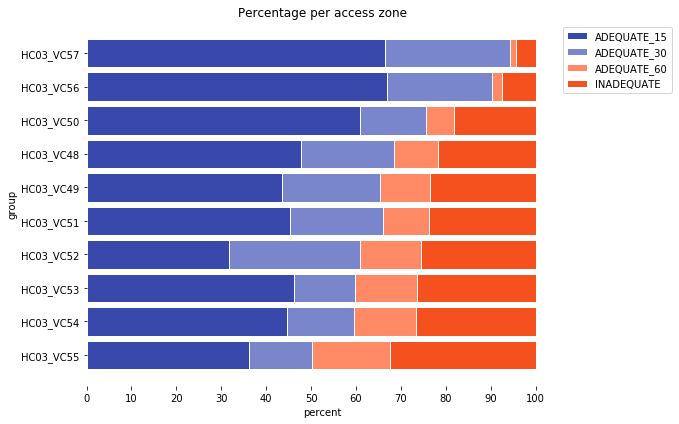

HC03_VC48 Percent; RACE - One race
HC03_VC49 Percent; RACE - One race - White
HC03_VC50 Percent; RACE - One race - Black or African American
HC03_VC51 Percent; RACE - One race - American Indian and Alaska Native
HC03_VC52 Percent; RACE - One race - American Indian and Alaska Native - Cherokee tribal grouping
HC03_VC53 Percent; RACE - One race - American Indian and Alaska Native - Chippewa tribal grouping
HC03_VC54 Percent; RACE - One race - American Indian and Alaska Native - Navajo tribal grouping
HC03_VC55 Percent; RACE - One race - American Indian and Alaska Native - Sioux tribal grouping
HC03_VC56 Percent; RACE - One race - Asian
HC03_VC57 Percent; RACE - One race - Asian - Asian Indian


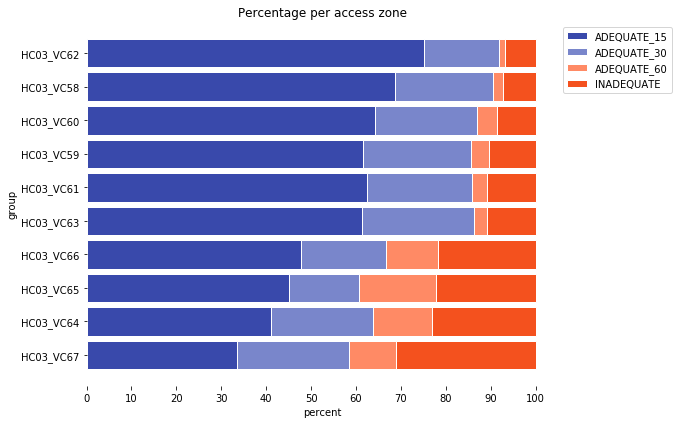

HC03_VC58 Percent; RACE - One race - Asian - Chinese
HC03_VC59 Percent; RACE - One race - Asian - Filipino
HC03_VC60 Percent; RACE - One race - Asian - Japanese
HC03_VC61 Percent; RACE - One race - Asian - Korean
HC03_VC62 Percent; RACE - One race - Asian - Vietnamese
HC03_VC63 Percent; RACE - One race - Asian - Other Asian
HC03_VC64 Percent; RACE - One race - Native Hawaiian and Other Pacific Islander
HC03_VC65 Percent; RACE - One race - Native Hawaiian and Other Pacific Islander - Native Hawaiian
HC03_VC66 Percent; RACE - One race - Native Hawaiian and Other Pacific Islander - Guamanian or Chamorro
HC03_VC67 Percent; RACE - One race - Native Hawaiian and Other Pacific Islander - Samoan


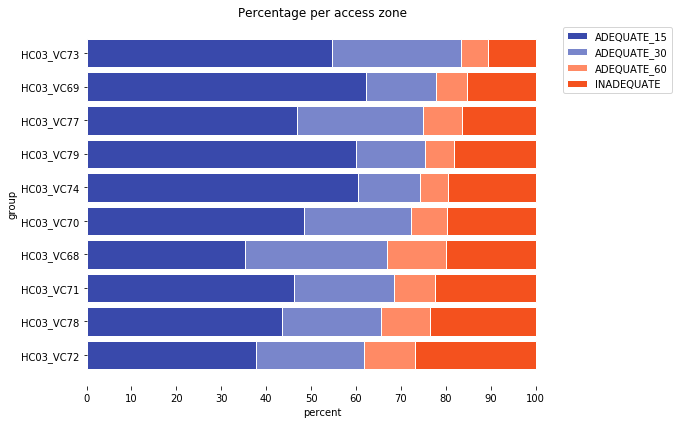

HC03_VC68 Percent; RACE - One race - Native Hawaiian and Other Pacific Islander - Other Pacific Islander
HC03_VC69 Percent; RACE - One race - Some other race
HC03_VC70 Percent; RACE - Two or more races
HC03_VC71 Percent; RACE - Two or more races - White and Black or African American
HC03_VC72 Percent; RACE - Two or more races - White and American Indian and Alaska Native
HC03_VC73 Percent; RACE - Two or more races - White and Asian
HC03_VC74 Percent; RACE - Two or more races - Black or African American and American Indian and Alaska Native
HC03_VC77 Percent; RACE - Race alone or in combination with one or more other races - Total population
HC03_VC78 Percent; RACE - Race alone or in combination with one or more other races - Total population - White
HC03_VC79 Percent; RACE - Race alone or in combination with one or more other races - Total population - Black or African American


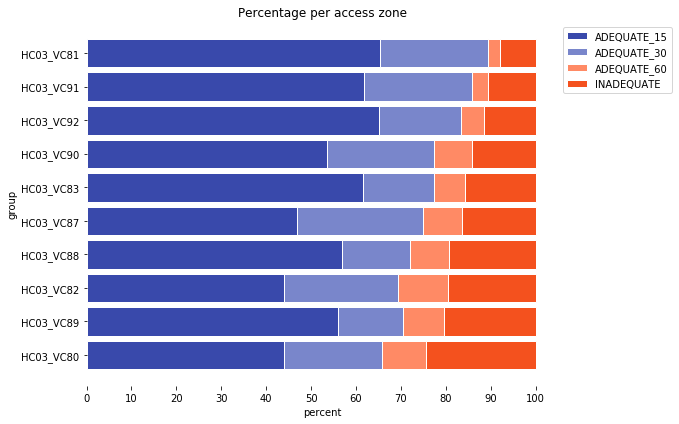

HC03_VC80 Percent; RACE - Race alone or in combination with one or more other races - Total population - American Indian and Alaska Native
HC03_VC81 Percent; RACE - Race alone or in combination with one or more other races - Total population - Asian
HC03_VC82 Percent; RACE - Race alone or in combination with one or more other races - Total population - Native Hawaiian and Other Pacific Islander
HC03_VC83 Percent; RACE - Race alone or in combination with one or more other races - Total population - Some other race
HC03_VC87 Percent; HISPANIC OR LATINO AND RACE - Total population
HC03_VC88 Percent; HISPANIC OR LATINO AND RACE - Total population - Hispanic or Latino (of any race)
HC03_VC89 Percent; HISPANIC OR LATINO AND RACE - Total population - Hispanic or Latino (of any race) - Mexican
HC03_VC90 Percent; HISPANIC OR LATINO AND RACE - Total population - Hispanic or Latino (of any race) - Puerto Rican
HC03_VC91 Percent; HISPANIC OR LATINO AND RACE - Total population - Hispanic or Latino 

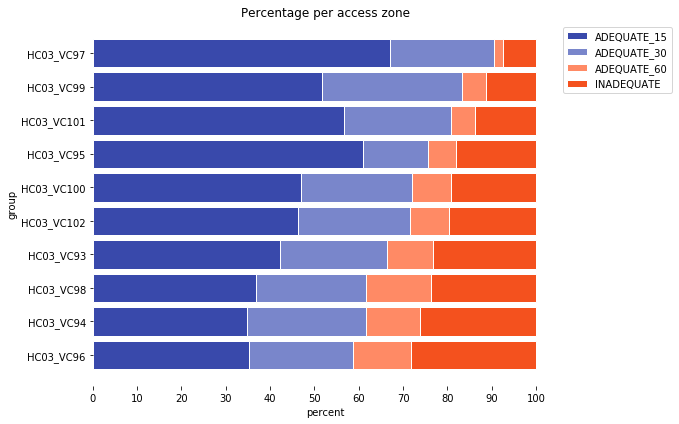

HC03_VC93 Percent; HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino
HC03_VC94 Percent; HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino - White alone
HC03_VC95 Percent; HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino - Black or African American alone
HC03_VC96 Percent; HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino - American Indian and Alaska Native alone
HC03_VC97 Percent; HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino - Asian alone
HC03_VC98 Percent; HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino - Native Hawaiian and Other Pacific Islander alone
HC03_VC99 Percent; HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino - Some other race alone
HC03_VC100 Percent; HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino - Two or more races
HC03_VC101 Percent; HISPANIC OR LATINO AND RACE - Total population - Not

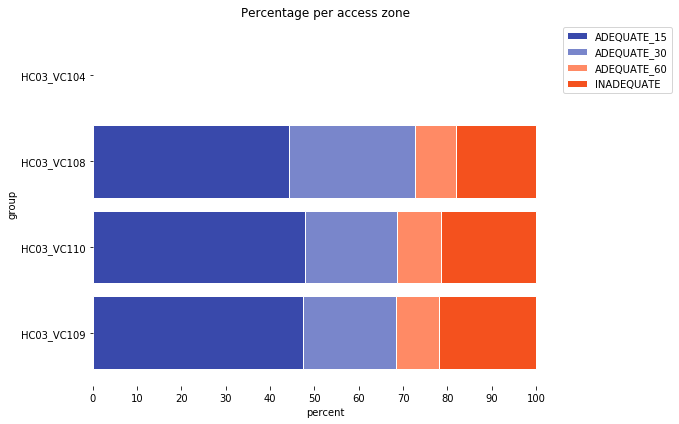

HC03_VC104 Percent; HISPANIC OR LATINO AND RACE - Total housing units
HC03_VC108 Percent; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population
HC03_VC109 Percent; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population - Male
HC03_VC110 Percent; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population - Female


In [41]:
data_profile_table, data_profile_table_columns = fetch_data_profile_table(5)
for n in range(int(len(data_profile_table.columns) / 10) + 1):
    try:
        preview_batch(n, data_profile_table, data_profile_table_columns)
    except KeyError:
        continue

In [38]:
data_profile_table_columns['HC03_VC98']

KeyError: 'HC03_VC98'